Original Data:
      Disease                        Symptoms                Test_Result  \
0  No Disease                     No Symptoms                     Normal   
1  Bronchitis                Persistent Cough      Lung Function Reduced   
2   Pneumonia  Chest Pain+Shortness of Breath  Inflammatory Markers High   
3   Influenza                   Fever+Fatigue               Positive Flu   
4  No Disease                      Mild Cough                     Normal   

              Diagnosis  
0           Observation  
1       Further Testing  
2  Aggressive Treatment  
3    Standard Treatment  
4           Observation  

Applying PC algorithm to learn causal structure...


  0%|          | 0/4 [00:00<?, ?it/s]


Learned Adjacency Matrix:
Disease: ['Symptoms']
Symptoms: ['Disease']
Test_Result: ['Diagnosis']
Diagnosis: ['Test_Result']

Evaluation Results:
Precision: 0.500
Recall: 0.500
F1 Score: 0.500
Number of True Edges: 4
Correctly Identified Edges: 2
Wrongly Identified Edges: 2
Missed Edges: 2


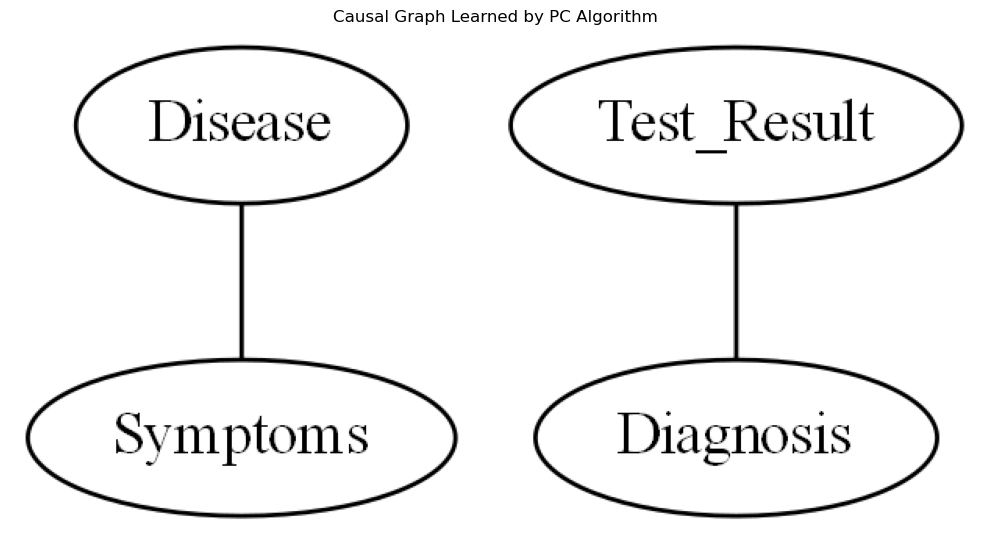


=== Edge Direction Analysis ===
Based on the learned graph structure and domain knowledge:
Expected: Disease → Symptoms (disease causes symptoms)
Expected: Disease → Test_Result (disease affects test results)
Expected: Symptoms → Diagnosis (symptoms influence diagnosis)
Expected: Test_Result → Diagnosis (test results guide diagnosis)

Structural Accuracy: 0.000
Total Possible Edges in Complete Graph: 12
Sparsity of Learned Graph: 0.333


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.GraphUtils import GraphUtils
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

def learn_causal_structure_with_pc(data_path='medical_causal_data.csv'):
    """
    Function to learn causal structure from data using PC algorithm
    
    Input:
    - data_path: path to data file, default 'medical_causal_data.csv'
    
    Output:
    - dict: containing learned graph structure, evaluation metrics and visualization results
    
    Functionality:
    - Read medical data and encode as numerical values
    - Apply PC algorithm to learn causal graph
    - Evaluate precision and recall of learned results
    - Visualize the learned causal graph
    """
    
    # Read data
    data = pd.read_csv(data_path)
    print("Original Data:")
    print(data.head())
    
    # Encode data as numerical values
    le_dict = {}
    encoded_data = data.copy()
    
    for column in data.columns:
        le = LabelEncoder()
        encoded_data[column] = le.fit_transform(data[column])
        le_dict[column] = le
    
    # Convert to numpy array for PC algorithm
    data_matrix = encoded_data.values
    
    # Apply PC algorithm
    print("\nApplying PC algorithm to learn causal structure...")
    cg = pc(data_matrix, alpha=0.05, indep_test='chisq', stable=True)
    
    # Get learned graph
    learned_graph = cg.G.graph
    nodes = list(data.columns)
    
    print("\nLearned Adjacency Matrix:")
    for i, row in enumerate(learned_graph):
        print(f"{nodes[i]}: {[nodes[j] for j, val in enumerate(row) if val != 0]}")
    
    # Define true causal structure (based on our data generation process)
    true_edges = [
        ('Disease', 'Symptoms'),
        ('Disease', 'Test_Result'), 
        ('Symptoms', 'Diagnosis'),
        ('Test_Result', 'Diagnosis')
    ]
    
    # Evaluate learning results
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    
    # Check learned edges
    for i in range(len(nodes)):
        for j in range(len(nodes)):
            if learned_graph[i, j] != 0:  # Learned edge
                edge = (nodes[i], nodes[j])
                if edge in true_edges:
                    true_positives += 1
                else:
                    false_positives += 1
    
    # Calculate missed true edges
    for edge in true_edges:
        i, j = nodes.index(edge[0]), nodes.index(edge[1])
        if learned_graph[i, j] == 0:
            false_negatives += 1
    
    # Calculate evaluation metrics
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"\nEvaluation Results:")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1 Score: {f1:.3f}")
    print(f"Number of True Edges: {len(true_edges)}")
    print(f"Correctly Identified Edges: {true_positives}")
    print(f"Wrongly Identified Edges: {false_positives}")
    print(f"Missed Edges: {false_negatives}")
    
    # Visualize causal graph
    plt.figure(figsize=(10, 8))
    pdy = GraphUtils.to_pydot(cg.G, labels=nodes)
    pdy.write_png('learned_causal_graph.png')
    
    # Display image
    img = plt.imread('learned_causal_graph.png')
    plt.imshow(img)
    plt.axis('off')
    plt.title('Causal Graph Learned by PC Algorithm')
    plt.tight_layout()
    plt.show()
    
    # Additional analysis: Edge direction interpretation
    print("\n=== Edge Direction Analysis ===")
    print("Based on the learned graph structure and domain knowledge:")
    
    # Define expected directions based on medical knowledge
    expected_directions = {
        ('Disease', 'Symptoms'): "Disease → Symptoms (disease causes symptoms)",
        ('Disease', 'Test_Result'): "Disease → Test_Result (disease affects test results)",
        ('Symptoms', 'Diagnosis'): "Symptoms → Diagnosis (symptoms influence diagnosis)",
        ('Test_Result', 'Diagnosis'): "Test_Result → Diagnosis (test results guide diagnosis)"
    }
    
    for edge in true_edges:
        if edge in expected_directions:
            print(f"Expected: {expected_directions[edge]}")
    
    # Calculate structural accuracy
    total_possible_edges = len(nodes) * (len(nodes) - 1)
    structural_accuracy = (len(true_edges) - false_positives - false_negatives) / len(true_edges)
    
    print(f"\nStructural Accuracy: {structural_accuracy:.3f}")
    print(f"Total Possible Edges in Complete Graph: {total_possible_edges}")
    print(f"Sparsity of Learned Graph: {(true_positives + false_positives) / total_possible_edges:.3f}")
    
    return {
        'learned_graph': learned_graph,
        'nodes': nodes,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'true_positives': true_positives,
        'false_positives': false_positives,
        'false_negatives': false_negatives,
        'structural_accuracy': structural_accuracy,
        'true_edges': true_edges
    }

# Run PC algorithm
results = learn_causal_structure_with_pc()